In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings


In [22]:

# Load the uploaded CSV file
file_path = r"e:\Nieuw dataset\Joined trends\joined_trend_sales_All.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007/01,0,1,0,0,20.0,37.0,9.0,8.0,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007/02,0,0,0,0,20.0,37.0,9.0,8.0,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007/03,0,0,0,0,20.0,37.0,9.0,8.0,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007/04,0,0,0,0,20.0,37.0,9.0,8.0,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007/05,0,2,0,0,18.0,32.0,9.0,7.4,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84


Reformat Time Column

In [23]:
# Convert 'Periode' to datetime format
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")

# Sort by time just in case
df = df.sort_values("Periode").reset_index(drop=True)

# Show the first 3 rows to confirm
df[["Periode", "Totaal_verkochte_wegvoertuigen"]].head(3)


,Periode,Totaal_verkochte_wegvoertuigen
0,2007-01-01,31
1,2007-02-01,39
2,2007-03-01,123


 Step 2: Sort by Time
Ensure the dataset is chronologically ordered.

🔹 Step 3: Create Lag Features
Use previous months’ target values to create lag_1, lag_2, …, which help the model recognize trends.

🔹 Step 4: Optional Rolling Features
Create moving averages or other window statistics to capture trends (e.g., 3-month mean).

🔹 Step 5: Encode Date Features
Extract month, quarter, year, etc., as new columns to help the model detect seasonality.

🔹 Step 6: Train-Test Split
Use a walk-forward or time-based split (not random) to evaluate models.

In [24]:

# Create 6 lag features for EV sales (Brownlee, Chapter 3, p. 42–44)
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)

# Drop rows with missing values due to lagging
df_lagged = df.dropna().reset_index(drop=True)


display(df_lagged.head(3))

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6
0,2007-07-01,0,1,0,0,14.0,22.0,9.0,6.2,1.451,...,1.057,1.069,1.063484,124,112.0,84.0,62.0,123.0,39.0,31.0
1,2007-08-01,0,1,0,0,12.0,17.0,9.0,5.6,1.415,...,1.045,1.068,1.052387,96,124.0,112.0,84.0,62.0,123.0,39.0
2,2007-09-01,0,1,0,0,10.0,12.0,9.0,5.0,1.422,...,1.056,1.094,1.081133,120,96.0,124.0,112.0,84.0,62.0,123.0


In [25]:
# Encode date features: extract year, month, and quarter from 'Periode'
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter

display(df_lagged)

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,Totaal_verkochte_wegvoertuigen,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter
0,2007-07-01,0,1,0,0,14.00,22.0,9.00,6.20,1.451,...,124,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3
1,2007-08-01,0,1,0,0,12.00,17.0,9.00,5.60,1.415,...,96,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3
2,2007-09-01,0,1,0,0,10.00,12.0,9.00,5.00,1.422,...,120,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3
3,2007-10-01,0,1,0,0,5.50,5.0,6.00,1.50,1.413,...,77,120.0,96.0,124.0,112.0,84.0,62.0,2007,10,4
4,2007-11-01,0,1,0,0,1.00,-2.0,3.00,-2.00,1.456,...,170,77.0,120.0,96.0,124.0,112.0,84.0,2007,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2024-09-01,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.912,...,28820,23683.0,25370.0,27731.0,26607.0,25326.0,29193.0,2024,9,3
207,2024-10-01,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.860,...,30491,28820.0,23683.0,25370.0,27731.0,26607.0,25326.0,2024,10,4
208,2024-11-01,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.914,...,32623,30491.0,28820.0,23683.0,25370.0,27731.0,26607.0,2024,11,4
209,2024-12-01,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.953,...,39594,32623.0,30491.0,28820.0,23683.0,25370.0,27731.0,2024,12,4


In [27]:
# Create a table with all columns, their descriptions, and datatypes
column_descriptions = {
    "Periode": "Month and year (YYYY-MM), timestamp of the observation",
    "thuis opladen": "Search volume or index for 'home charging'",
    "elektrische auto": "Search volume or index for 'electric car'",
    "hybride elektrisch": "Search volume or index for 'hybrid electric'",
    "Bijtellingspercentage": "Additional tax rate for business drivers",
    "Consumentenvertrouwen": "Consumer confidence index",
    "Economisch klimaat": "Economic climate index",
    "Koopbereidheid": "Willingness to buy index",
    "Grote aankopen": "Index for major purchases",
    "BenzineEuro95_1_first": "Euro95 gasoline price at the start of the month",
    "BenzineEuro95_1_last": "Euro95 gasoline price at the end of the month",
    "BenzineEuro95_1_min": "Lowest Euro95 gasoline price in the month",
    "BenzineEuro95_1_max": "Highest Euro95 gasoline price in the month",
    "BenzineEuro95_1_mean": "Average Euro95 gasoline price in the month",
    "Diesel_2_first": "Diesel price at the start of the month",
    "Diesel_2_last": "Diesel price at the end of the month",
    "Diesel_2_min": "Lowest diesel price in the month",
    "Diesel_2_max": "Highest diesel price in the month",
    "Diesel_2_mean": "Average diesel price in the month",
    "Totaal_verkochte_wegvoertuigen": "Total number of road vehicles sold in the month",
    "Saleslag_1": "Sales figure 1 month ago",
    "Saleslag_2": "Sales figure 2 months ago",
    "Saleslag_3": "Sales figure 3 months ago",
    "Saleslag_4": "Sales figure 4 months ago",
    "Saleslag_5": "Sales figure 5 months ago",
    "Saleslag_6": "Sales figure 6 months ago",
    "year": "Year of the observation",
    "month": "Month of the observation",
    "quarter": "Quarter of the observation"
}

# Get datatypes from the train DataFrame
col_types = train.dtypes.astype(str)

# Build the table as a DataFrame
table = pd.DataFrame({
    "Column": list(train.columns),
    "Description": [column_descriptions.get(col, "") for col in train.columns],
    "Data Type": [col_types[col] for col in train.columns]
})

display(table)

,Column,Description,Data Type
0,Periode,"Month and year (YYYY-MM), timestamp of the obs...",datetime64[ns]
1,thuis opladen,Search volume or index for 'home charging',int64
2,elektrische auto,Search volume or index for 'electric car',int64
3,hybride elektrisch,Search volume or index for 'hybrid electric',int64
4,Bijtellingspercentage,Additional tax rate for business drivers,int64
5,Consumentenvertrouwen,Consumer confidence index,float64
6,Economisch klimaat,Economic climate index,float64
7,Koopbereidheid,Willingness to buy index,float64
8,Grote aankopen,Index for major purchases,float64
9,BenzineEuro95_1_first,Euro95 gasoline price at the start of the month,float64


In [17]:
# Walk-forward split: start with 80% as initial train, then predict one by one
initial_train_size = int(len(df_lagged) * 0.8)
walkforward_predictions = []
walkforward_actuals = []

X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    
    walkforward_predictions.append(y_pred)
    walkforward_actuals.append(y_test)

print(f"Walk-forward predictions: {len(walkforward_predictions)} points")


Walk-forward predictions: 43 points


In [ ]:
# "Walk-forward predictions: 43 points" betekent dat er 43 voorspellingen zijn gedaan met de walk-forward validatie.
# Dit houdt in dat het model telkens één maand vooruit voorspelt, op basis van alle voorgaande data.
# In dit geval zijn er dus 43 maanden in de testperiode waarvoor een voorspelling is gemaakt.


Er zijn 43 voorspellingen gedaan met walk-forward validatie.


In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define your feature columns (drop columns you shouldn't use as predictors)
drop_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen']
target_col = 'Totaal_verkochte_wegvoertuigen'
feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

# Extract features and target for train/test
X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

# Train model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"📊 Evaluation Metrics (Hold-Out)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


📊 Evaluation Metrics (Hold-Out)
MAE:  8173.47
RMSE: 10039.13
R²:   -1.5926
MAPE: 33.64%


In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Extract data
X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

# Start walk-forward
initial_train_size = int(len(df_lagged) * 0.8)
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged)):
    # Split up to i (train), predict i (test point)
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    
    predictions.append(y_pred)
    actuals.append(y_test)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100

print("📈 Walk-Forward Validation Results")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


📈 Walk-Forward Validation Results
MAE:  3278.99
RMSE: 4486.29
R²:   0.4822
MAPE: 13.93%


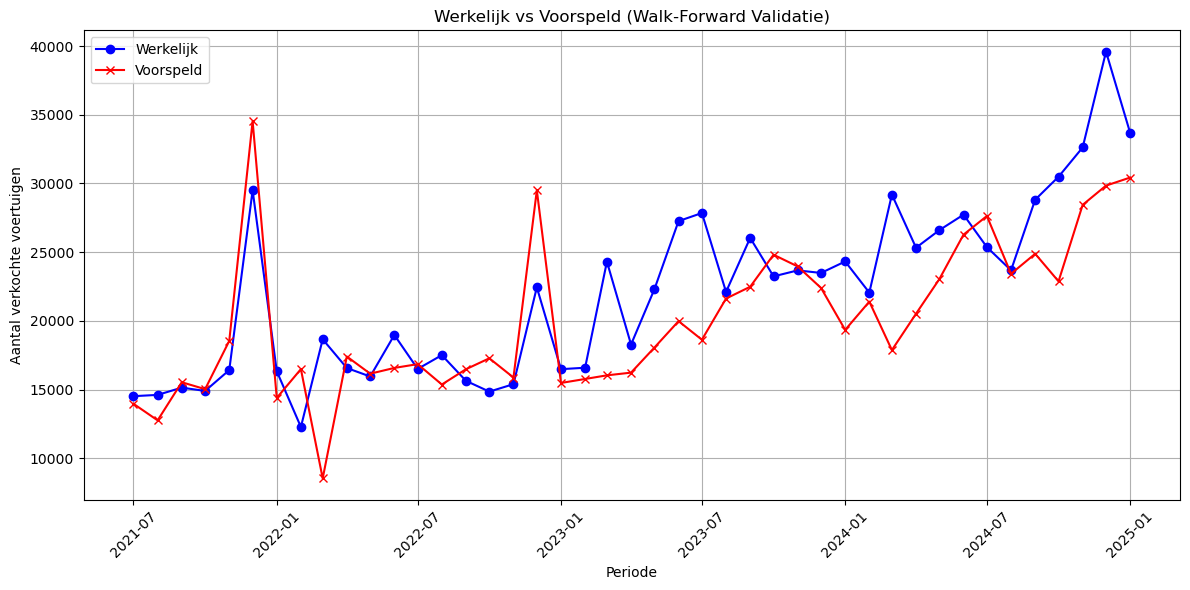

In [14]:
import matplotlib.pyplot as plt

# Create timeline for the predictions
start_index = initial_train_size
prediction_dates = df_lagged["Periode"].iloc[start_index:].values

plt.figure(figsize=(12, 6))
plt.plot(prediction_dates, actuals, label="Werkelijk", marker='o', color='blue')
plt.plot(prediction_dates, predictions, label="Voorspeld", marker='x', color='red')

plt.title("Werkelijk vs Voorspeld (Walk-Forward Validatie)")
plt.xlabel("Periode")
plt.ylabel("Aantal verkochte voertuigen")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


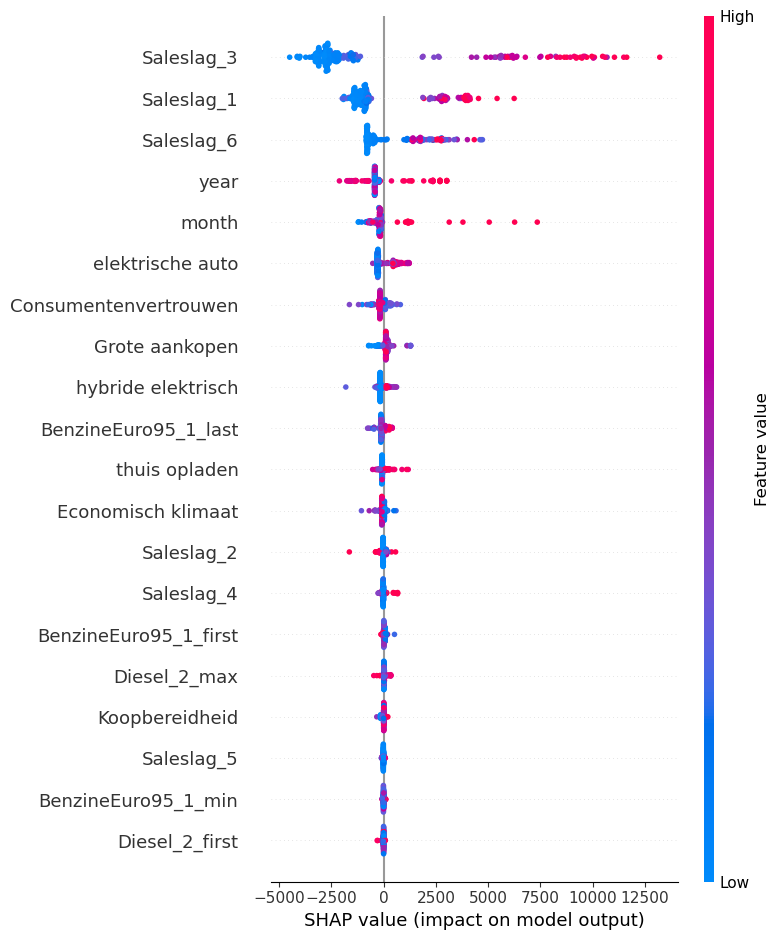

In [20]:
import shap

# Fit the model on the full training set for SHAP analysis
model.fit(df_lagged[feature_cols], df_lagged[target_col])

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(df_lagged[feature_cols])

# Plot summary of feature importance
shap.summary_plot(shap_values, df_lagged[feature_cols], feature_names=feature_cols)

In [21]:
import numpy as np

# Calculate mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_feature_importance = dict(zip(feature_cols, mean_abs_shap))

# Sort features by importance (ascending)
sorted_features = sorted(shap_feature_importance, key=shap_feature_importance.get)

# Drop the 5 least important features (you can adjust this number)
n_drop = 5
reduced_feature_cols = [f for f in feature_cols if f not in sorted_features[:n_drop]]

# Retrain model with reduced features
X_train_reduced = train[reduced_feature_cols]
y_train_reduced = train[target_col]
X_test_reduced = test[reduced_feature_cols]
y_test_reduced = test[target_col]

model_reduced = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_reduced.fit(X_train_reduced, y_train_reduced)
y_pred_reduced = model_reduced.predict(X_test_reduced)

# Evaluate
mae_reduced = mean_absolute_error(y_test_reduced, y_pred_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_test_reduced, y_pred_reduced))
r2_reduced = r2_score(y_test_reduced, y_pred_reduced)
mape_reduced = np.mean(np.abs((y_test_reduced - y_pred_reduced) / y_test_reduced)) * 100

print("📊 Reduced Feature Evaluation (Hold-Out)")
print(f"MAE:  {mae_reduced:.2f}")
print(f"RMSE: {rmse_reduced:.2f}")
print(f"R²:   {r2_reduced:.4f}")
print(f"MAPE: {mape_reduced:.2f}%")
print(f"Dropped features: {sorted_features[:n_drop]}")

📊 Reduced Feature Evaluation (Hold-Out)
MAE:  8168.49
RMSE: 10034.52
R²:   -1.5902
MAPE: 33.62%
Dropped features: ['quarter', 'Bijtellingspercentage', 'Diesel_2_mean', 'BenzineEuro95_1_mean', 'Diesel_2_min']
